In [13]:
import pandas as pd
import matplotlib.pyplot as plt

#df = pd.read_csv(r"C:\Users\zahri\anaconda_projects\AsaiProjekt\Asai-Projekt\heart.csv")
df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart.csv")

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")
# Ersten Blick auf die Daten werfen
#print(df.head())             # Zeigt die ersten 5 Zeilen
#print(df.info())             # Gibt Datentypen und Nullwerte an
#print(df.describe())         # Statistische Übersicht (Mittelwert, Std., etc.)

# Optional: Spaltennamen anzeigen
#print("Spalten:", df.columns.tolist())

Anzahl der Zeilen (Patienten): 1025
Anzahl der Spalten (Features): 14


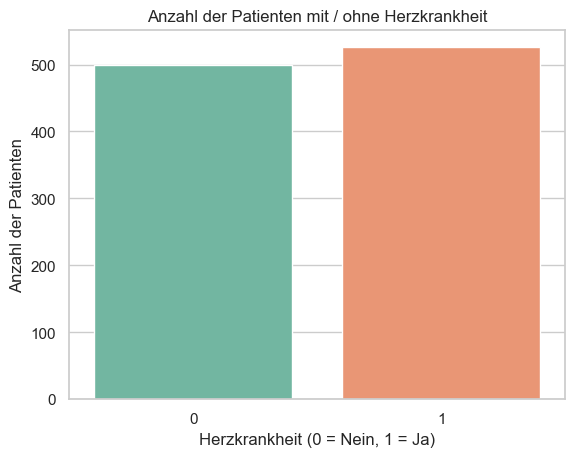

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set(style="whitegrid")

# Balkendiagramm OHNE FutureWarning
sns.countplot(x='target', data=df, hue='target', palette='Set2', legend=False)

# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Plot anzeigen
plt.show()